# Anuj Rajan Lalla
# B22AI061
# Speech PA2 - Q2

# Task A

## 1. Dataset downloaded and stored locally

## 2. Python code for extracing MFCC's

In [1]:
import os
import random
import time
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# Number of MFCC coefficients to compute (excluding the 0th later)
n_mfcc = 13
# Directory where the language-specific audio dataset is stored
dataset_dir = "Language Detection Dataset" 
# Number of parallel jobs to run for processing audio files
N_JOBS = 8

def load_mfcc(file_path, n_mfcc=13):
    """
    Load an audio file and compute its MFCC features.

    Parameters:
    - file_path: Path to the audio file.
    - n_mfcc: Number of MFCC coefficients to compute.

    Returns:
    - mfcc[1:, :]: MFCC feature matrix after removing the 0th coefficient.
    - sr: Sample rate of the audio file.
    """
    # Load audio file with its original sampling rate
    y, sr = librosa.load(file_path, sr=None)
    # Compute the MFCCs from the audio signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Remove the 0th coefficient (often representing overall energy) and return the rest
    return mfcc[1:, :], sr

def process_file(file_path, n_mfcc=13):
    """
    Process a single audio file to extract its MFCC features.

    Parameters:
    - file_path: Path to the audio file.
    - n_mfcc: Number of MFCC coefficients to compute.

    Returns:
    - A tuple containing the filename and a tuple of (mfcc_array, sr) if successful.
    - None if there is an error during processing.
    """
    try:
        mfcc_array, sr = load_mfcc(file_path, n_mfcc=n_mfcc)
        # Return the base filename and its MFCC features with sample rate
        return os.path.basename(file_path), (mfcc_array, sr)
    except Exception as e:
        # Print error message if something goes wrong during processing
        print(f"Error processing {file_path}: {e}")
        return None

def extract_features_all(lang_dir, n_mfcc=13, n_jobs=N_JOBS):
    """
    Extract MFCC features from all .mp3 audio files in a specified directory.

    Parameters:
    - lang_dir: Directory containing audio files for a specific language.
    - n_mfcc: Number of MFCC coefficients to compute.
    - n_jobs: Number of parallel jobs to use.

    Returns:
    - A dictionary mapping each audio file's name to its (mfcc_array, sr) tuple.
    """
    # Create a list of file paths for all .mp3 files in the given directory
    audio_files = [os.path.join(lang_dir, f) for f in os.listdir(lang_dir) if f.lower().endswith('.mp3')]
    if len(audio_files) == 0:
        print("No audio files found in", lang_dir)
        return {}

    # Process each file in parallel using joblib and show progress with tqdm
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_file)(file_path, n_mfcc=n_mfcc) 
        for file_path in tqdm(audio_files, desc=f"Processing {os.path.basename(lang_dir)}")
    )
    
    # Build a dictionary from the results, ignoring any files that failed processing
    lang_features = {
        fname: (mfcc_array, sr)
        for result in results
        if result is not None
        for fname, (mfcc_array, sr) in [result]
    }
    return lang_features


# Code for visualizing some samples

In [2]:
def visualize_samples_subset(features_dict, language, samples=4, grid_dims=(2,2), n_mfcc=13):
    """
    Visualize a few MFCC samples for a given language.
    
    Parameters:
        features_dict (dict): Dictionary mapping file names to (mfcc, sr) tuples.
        language (str): Language name for display purposes.
        samples (int): Number of random samples to visualize.
        grid_dims (tuple): Dimensions for subplot grid.
        n_mfcc (int): Number of MFCC coefficients (not used here, kept for consistency).
    """
    file_list = list(features_dict.keys())
    if not file_list:
        print(f"No files found for {language}.")
        return

    # Select random files for visualization
    selected_files = random.sample(file_list, min(samples, len(file_list)))
    
    # Set up the subplot grid
    fig, axes = plt.subplots(grid_dims[0], grid_dims[1], figsize=(12, 8))
    axes = axes.flatten()

    # Plot the MFCCs for each selected file
    for idx, file_name in enumerate(tqdm(selected_files, desc=f"Visualizing {language}")):
        try:
            mfcc, sr = features_dict[file_name]
            img = librosa.display.specshow(mfcc, sr=sr, hop_length=512, x_axis='time', ax=axes[idx])
            axes[idx].set_title(f"{language}: {file_name}", fontsize=8)
            fig.colorbar(img, ax=axes[idx])
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            axes[idx].text(0.5, 0.5, "Error", ha='center')

    for j in range(len(selected_files), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Code of computing statistics of a language ( I have extracted MFCC's of all languages and computed the statistics)

In [9]:
def compute_statistics_subset(features_dict, n_mfcc=13):
    """
    Compute overall mean and variance of MFCC coefficients from the provided dictionary.
    Each value in features_dict is assumed to be a tuple: (mfcc_array, sr)
    
    Returns: (overall_mean, overall_var), each of shape (n_mfcc-1,).
    """
    all_means, all_vars = [], []
    for file_name, value in features_dict.items():
        try:
            mfcc, sr = value  # Unpack the tuple: use mfcc only.
            mean_coeff = np.mean(mfcc, axis=1)  # shape: (n_mfcc-1,)
            var_coeff = np.var(mfcc, axis=1)
            all_means.append(mean_coeff)
            all_vars.append(var_coeff)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    if all_means and all_vars:
        overall_mean = np.mean(np.vstack(all_means), axis=0)
        overall_var = np.mean(np.vstack(all_vars), axis=0)
        return overall_mean, overall_var
    else:
        return None, None



# Extracting MFCC's for all languages for all samples

In [5]:
all_mfcc_features = {}  # Global dictionary to store features for all languages
languages = [lang for lang in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, lang))]

# For each language, extract features and store them.
for language in languages:
    print(f"\nExtracting features for {language}...")
    lang_dir = os.path.join(dataset_dir, language)
    features_all = extract_features_all(lang_dir, n_mfcc=n_mfcc, n_jobs=N_JOBS)
    all_mfcc_features[language] = features_all  # Store the features for this language





Extracting features for Bengali...


Processing Bengali: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 27258/27258 [05:04<00:00, 89.42it/s]



Extracting features for Gujarati...


Processing Gujarati: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 26441/26441 [04:47<00:00, 92.07it/s]



Extracting features for Hindi...


Processing Hindi: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 25462/25462 [04:39<00:00, 90.95it/s]



Extracting features for Kannada...


Processing Kannada: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 22208/22208 [03:42<00:00, 99.70it/s]



Extracting features for Malayalam...


Processing Malayalam: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 24044/24044 [04:09<00:00, 96.33it/s]



Extracting features for Marathi...


Processing Marathi: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 25379/25379 [04:40<00:00, 90.35it/s]



Extracting features for Punjabi...


Processing Punjabi: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 26229/26229 [04:46<00:00, 91.56it/s]



Extracting features for Tamil...


Processing Tamil: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 24196/24196 [04:24<00:00, 91.62it/s]



Extracting features for Telugu...


Processing Telugu: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 23656/23656 [04:26<00:00, 88.61it/s]



Extracting features for Urdu...


Processing Urdu: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 31960/31960 [05:59<00:00, 89.02it/s]


## 3. Plotting MFCC sets of 8 samples for Hindi , Gujarati and Punjabi

Visualizing Hindi: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.44it/s]


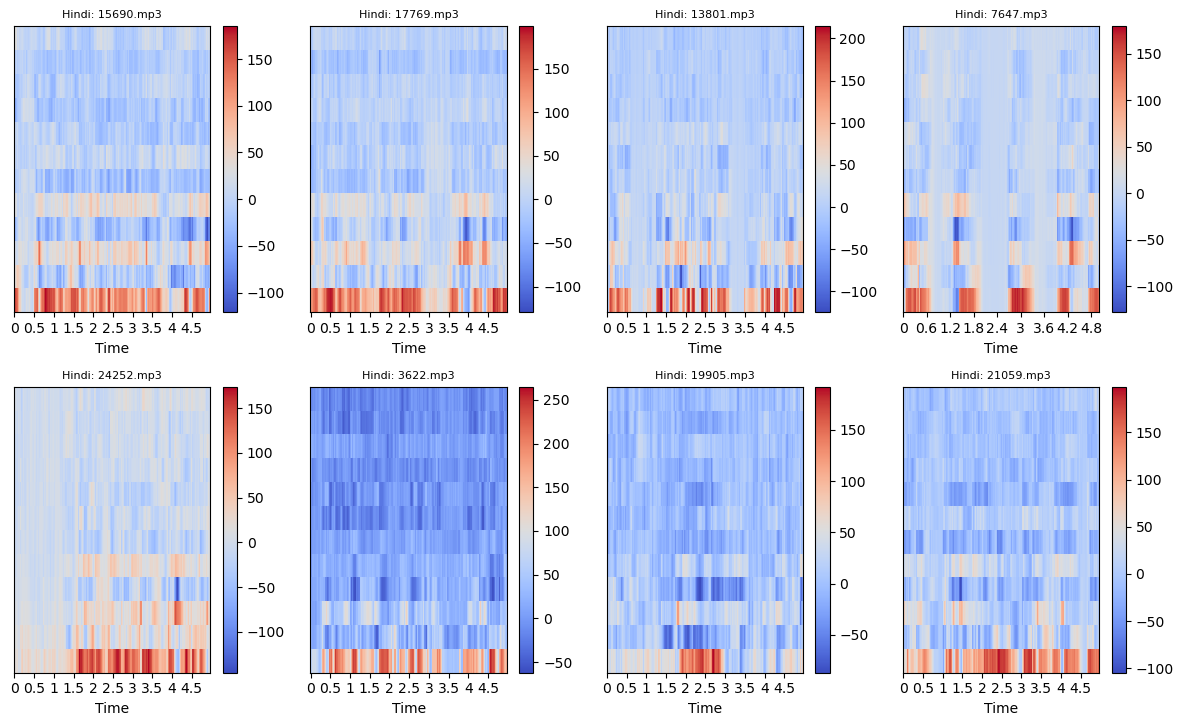

In [24]:
language = "Hindi"
visualize_samples_subset(all_mfcc_features[language], language, samples=8, grid_dims=(2,4), n_mfcc=13)

Visualizing Gujarati: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.34it/s]


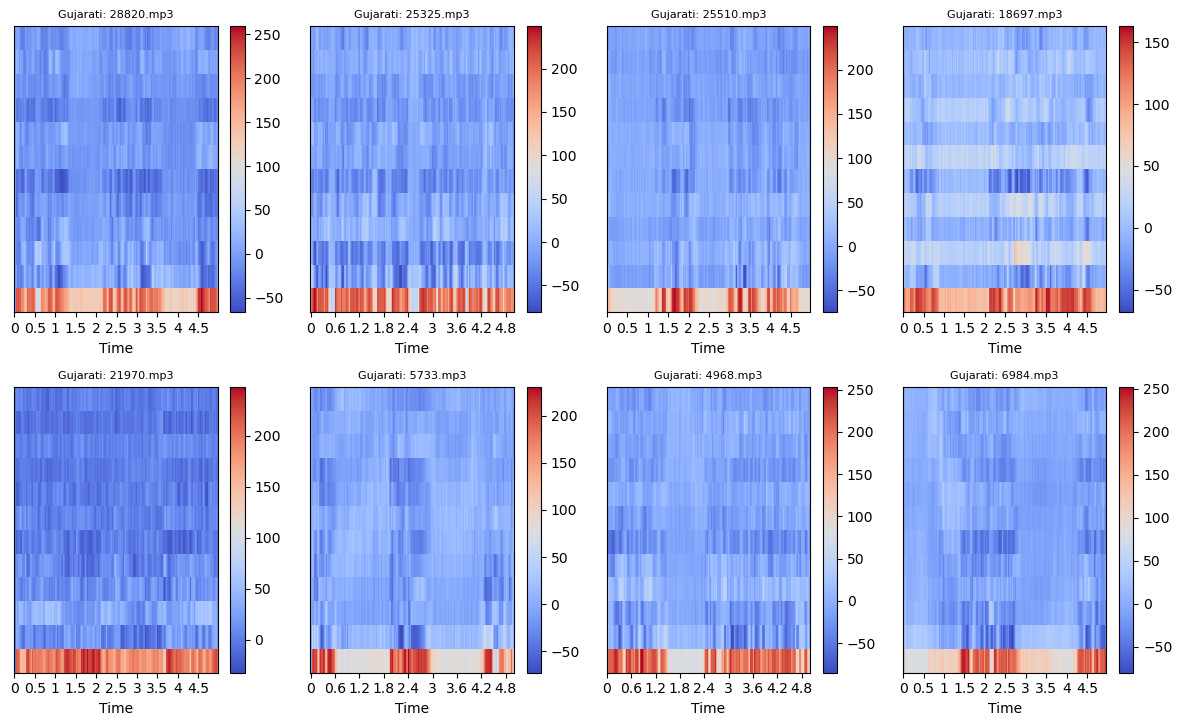

In [27]:
language = "Gujarati"
visualize_samples_subset(all_mfcc_features[language], language, samples=8, grid_dims=(2,4), n_mfcc=13)

Visualizing Punjabi: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.15it/s]


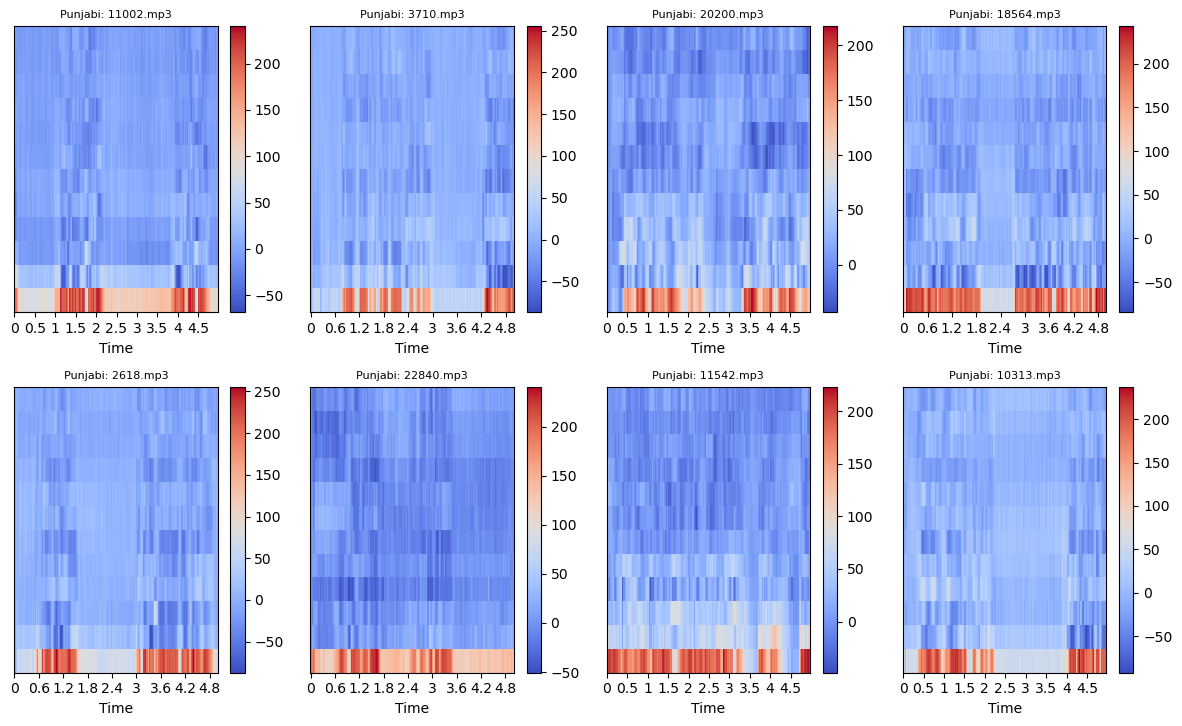

In [28]:
language = "Punjabi"
visualize_samples_subset(all_mfcc_features[language], language, samples=8, grid_dims=(2,4), n_mfcc=13)

# Plots for remaining languages together

Visualizing Tamil: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.08it/s]


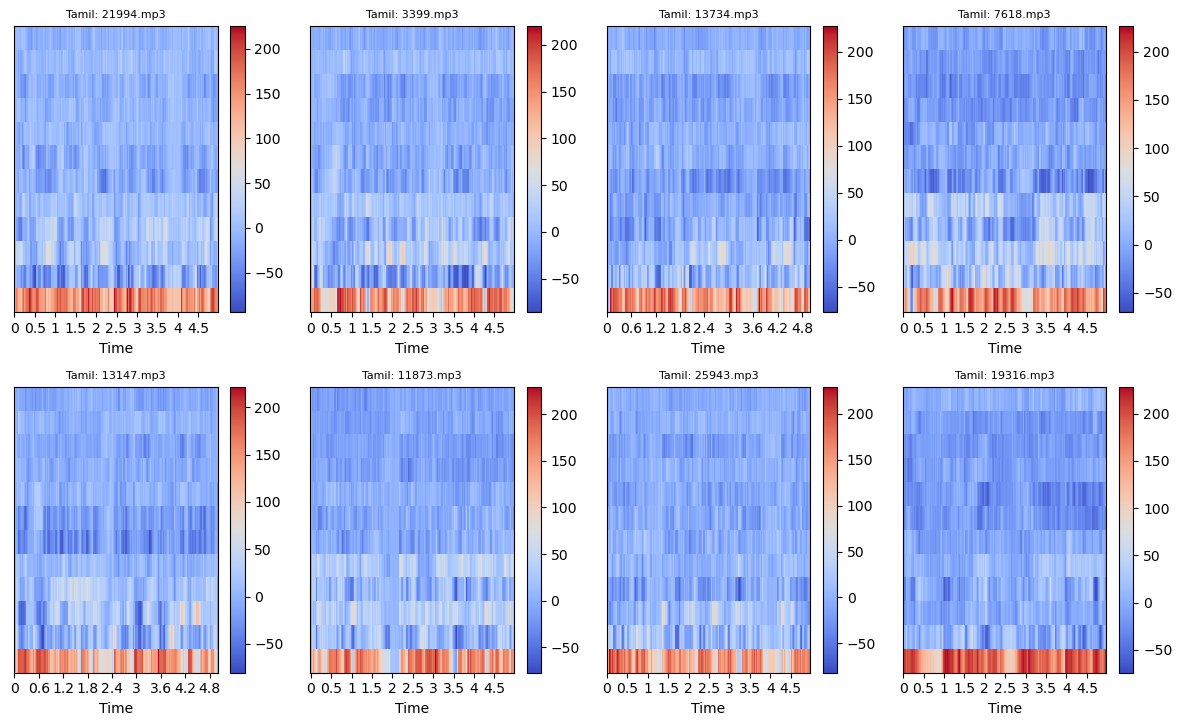

Visualizing Telugu: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.01it/s]


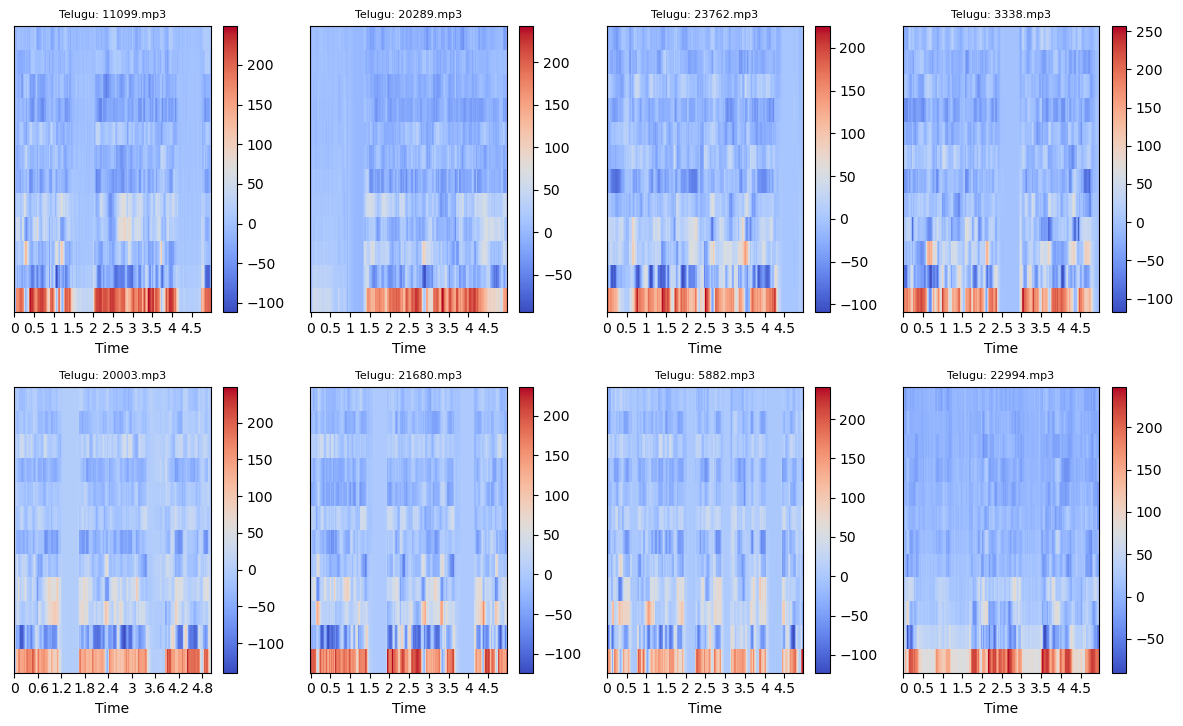

Visualizing Malayalam: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.20it/s]


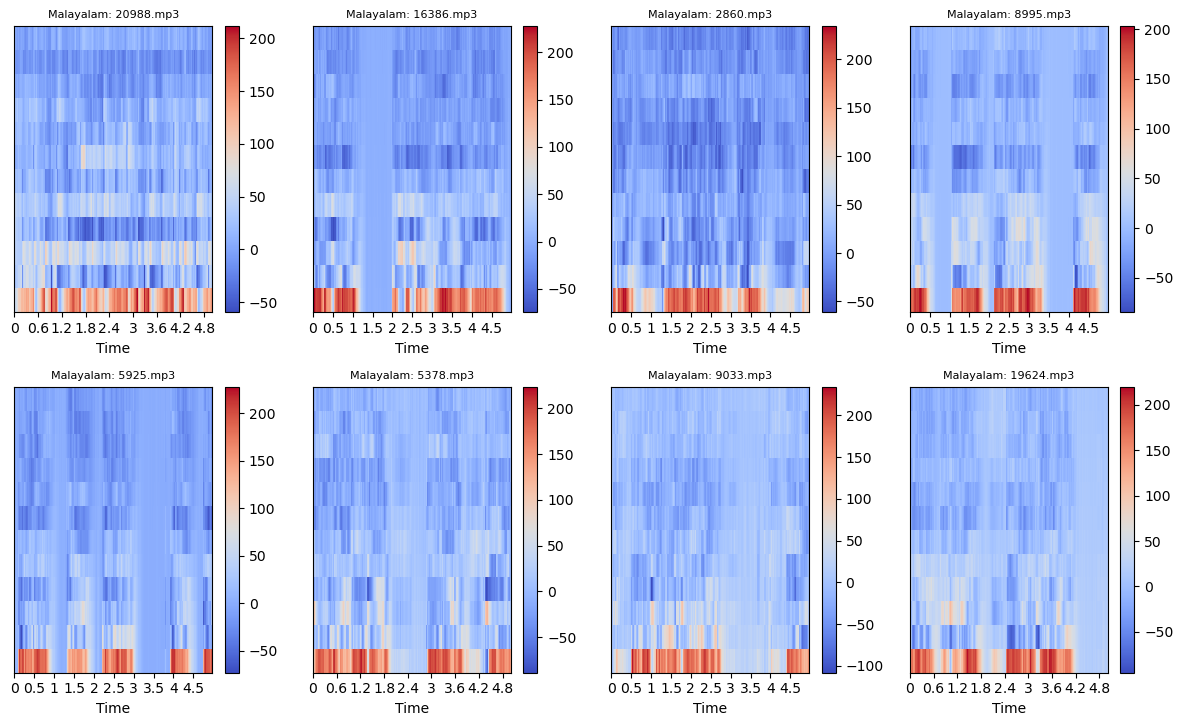

Visualizing Marathi: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.83it/s]


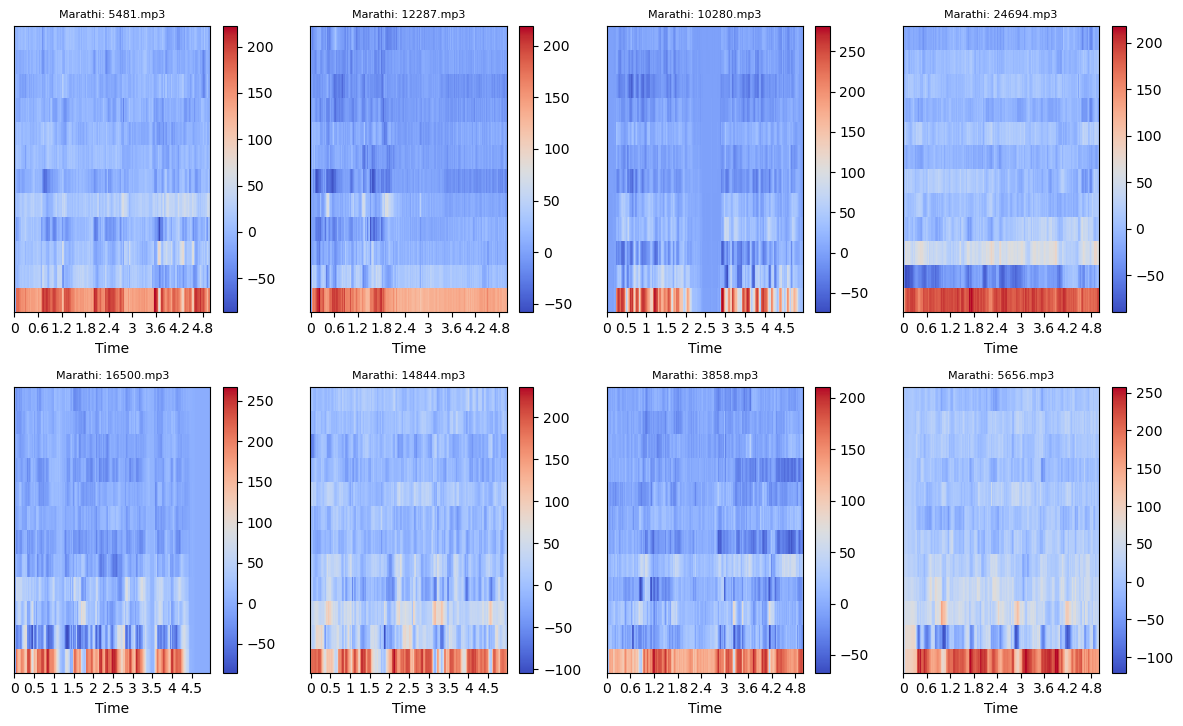

Visualizing Kannada: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.05it/s]


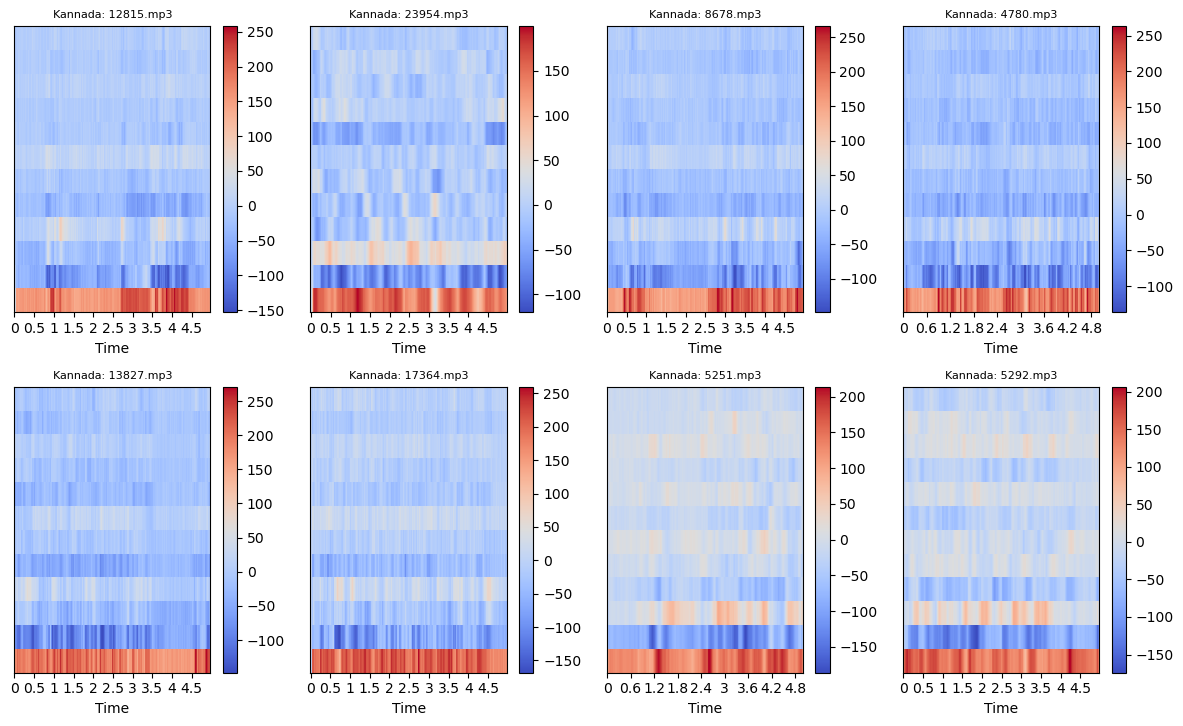

Visualizing Urdu: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.33it/s]


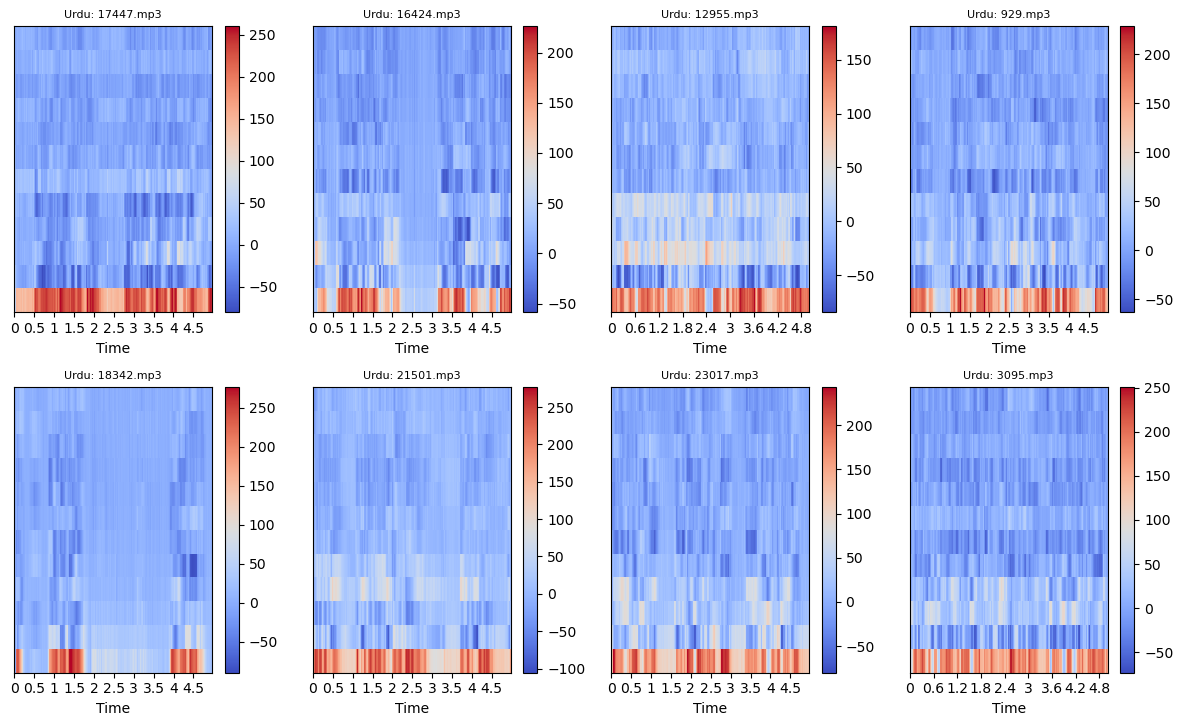

Visualizing Bengali: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.03it/s]


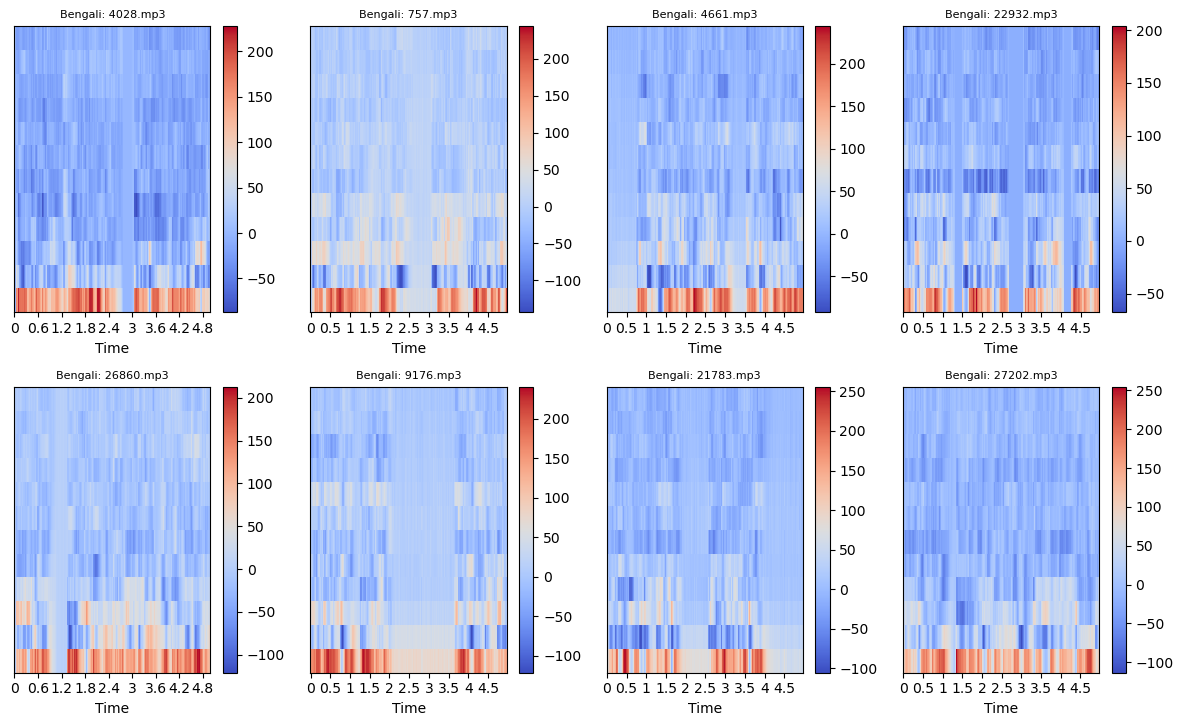

In [30]:
language = ['Tamil','Telugu','Malayalam','Marathi','Kannada','Urdu','Bengali']
for language in language:
    visualize_samples_subset(all_mfcc_features[language], language, samples=8, grid_dims=(2,4), n_mfcc=13)

## 4a. Statistics computed for all the languages


Computing statistics for Bengali...

Overall Mean of MFCC coefficients for Bengali: [133.27261     9.763282   23.284554    6.414176    6.146011   -6.3243275
   2.1420667   1.4336369  -7.0371795  -2.8937688  -1.1886517  -3.6594875]
Overall Variance of MFCC coefficients for Bengali: [3555.33     1502.6083    786.72766   560.03876   352.17853   284.50833
  181.20691   164.84692   161.44893   150.78874   101.967575  103.82922 ]

Computing statistics for Gujarati...

Overall Mean of MFCC coefficients for Gujarati: [ 1.4546587e+02 -2.5344486e+00 -2.8625662e+00  2.7789853e+00
 -4.3865457e-02 -1.2048980e+01 -3.4197686e+00 -3.7429760e+00
 -1.2561281e+01 -6.9137168e+00 -3.2811105e+00 -5.2808137e+00]
Overall Variance of MFCC coefficients for Gujarati: [3176.5676   881.05475  345.05344  260.57568  203.00864  308.547
  168.35262  120.6391   185.1345    99.38317  116.54397  142.78633]

Computing statistics for Hindi...

Overall Mean of MFCC coefficients for Hindi: [102.64927      0.32252324  32.685

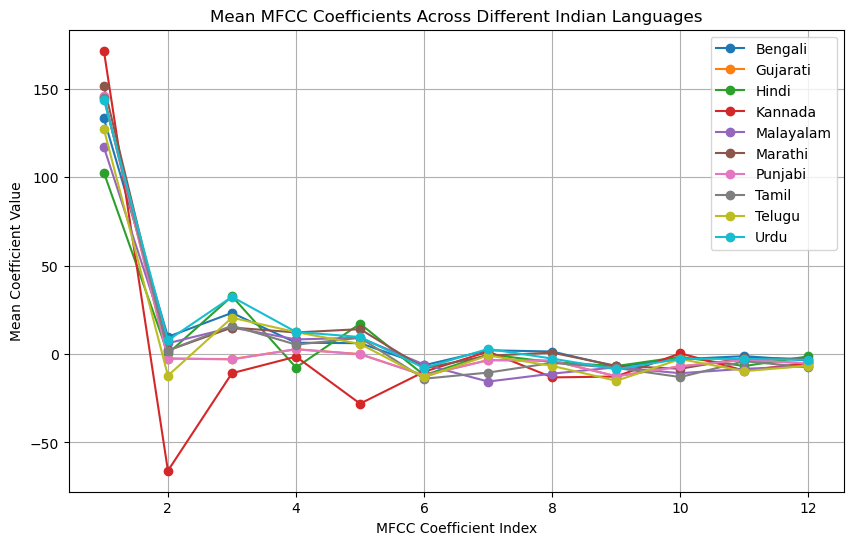

In [10]:


language_stats = {}  # Dictionary to hold mean MFCC statistics for each language

for language, features in all_mfcc_features.items():
    print(f"\nComputing statistics for {language}...")
    # Compute statistics using the features for the given language
    overall_mean, overall_var = compute_statistics_subset(features, n_mfcc=n_mfcc)
    if overall_mean is not None:
        language_stats[language] = overall_mean
        print(f"\nOverall Mean of MFCC coefficients for {language}: {overall_mean}")
        print(f"Overall Variance of MFCC coefficients for {language}: {overall_var}")
    else:
        print(f"No statistics computed for {language}.")

# Plot the combined histogram (line plot) for all languages.
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
coeff_indices = np.arange(1, n_mfcc)  # 0th coefficient was removed during extraction
for language, mean_values in language_stats.items():
    plt.plot(coeff_indices, mean_values, marker='o', label=language)
plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Mean Coefficient Value")
plt.title("Mean MFCC Coefficients Across Different Indian Languages")
plt.legend()
plt.grid(True)
plt.show()


# Plotting histograms which help in understandin outliers

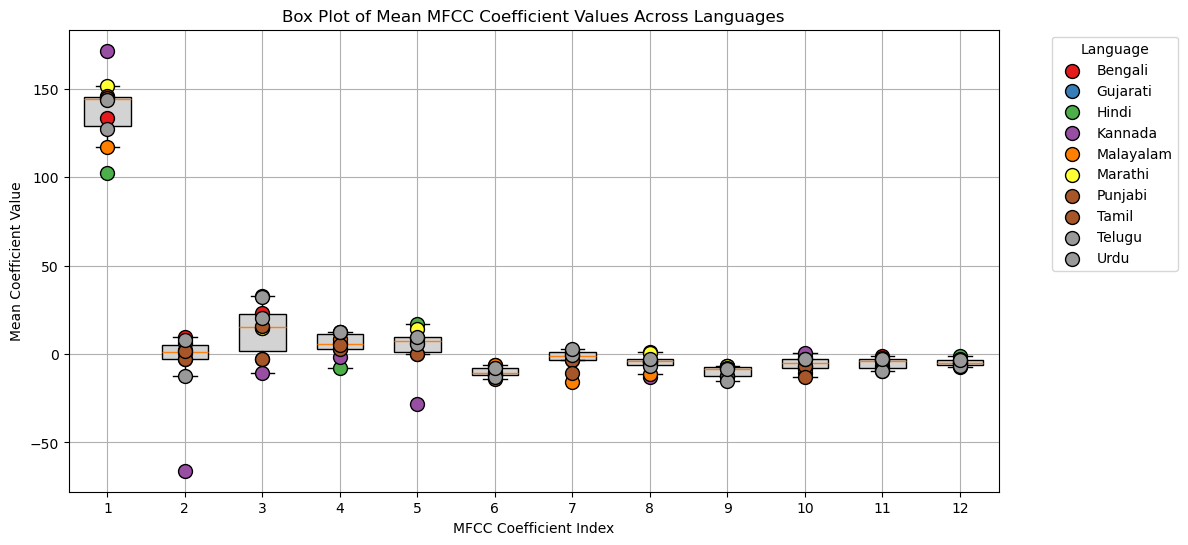

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Number of coefficients (after removing the 0th coefficient)
num_coeff = n_mfcc - 1  

coeff_data = []
for i in range(num_coeff):
    # For coefficient index i, collect the value from each language.
    values = [language_stats[lang][i] for lang in language_stats.keys()]
    coeff_data.append(values)

plt.figure(figsize=(12, 6))

box = plt.boxplot(coeff_data, positions=np.arange(1, num_coeff+1), patch_artist=True, widths=0.6)

for patch in box['boxes']:
    patch.set_facecolor('lightgray')

cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in np.linspace(0, 1, len(language_stats))]

for idx, lang in enumerate(language_stats.keys()):
    language_values = language_stats[lang]
    plt.scatter(np.arange(1, num_coeff+1), language_values, 
                color=colors[idx], edgecolor='black', s=100, label=lang, zorder=3)

plt.xlabel("MFCC Coefficient Index")
plt.ylabel("Mean Coefficient Value")
plt.title("Box Plot of Mean MFCC Coefficient Values Across Languages")
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# Task B

## Preprocessing for Task B

## 1. Utilizing MFCC features extracted in Task A to build classifier in this case ( Simple Neural Network)

In [14]:
def pad_mfcc(mfcc, target_shape):
    """
    Pads or truncates a 2D MFCC array to the fixed target shape.
    target_shape: (n_coeff, time_steps)
    """
    padded = np.zeros(target_shape)
    h = min(mfcc.shape[0], target_shape[0])
    w = min(mfcc.shape[1], target_shape[1])
    padded[:h, :w] = mfcc[:h, :w]
    return padded

def flatten_features_and_labels(all_features, target_shape):
    """
    Converts a nested dictionary of MFCC features (by language and file) into two arrays:
      - X: padded MFCC arrays with shape (samples, n_coeff, time_steps)
      - y: corresponding language labels.
    """
    X, y = [], []
    for language, file_dict in all_features.items():
        for file_name, (mfcc, sr) in file_dict.items():
            X.append(pad_mfcc(mfcc, target_shape))
            y.append(language)
    return np.array(X), np.array(y)


target_shape = (12, 200)
X, y_labels = flatten_features_and_labels(all_mfcc_features, target_shape)

# Encode labels as integers.
unique_labels = sorted(list(set(y_labels)))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_to_idx[label] for label in y_labels])

print("Feature array shape:", X.shape)  
print("Labels shape:", y.shape)


Feature array shape: (256824, 12, 200)
Labels shape: (256824,)


# Seeding for reproducibility

In [36]:
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

## 3. Data preprocessing steps defined

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data (80% train, 20% test) with stratification.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

# Normalize the features globally.
scaler = StandardScaler()
# Flatten the features for scaler fitting.
X_train_flat = X_train.reshape(X_train.shape[0], -1)
scaler.fit(X_train_flat)

X_train_norm = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

print("Normalized train shape:", X_train_norm.shape)
print("Normalized test shape:", X_test_norm.shape)

Normalized train shape: (205459, 12, 200)
Normalized test shape: (51365, 12, 200)


## 2. Custom Dataset, dataloaders and definition for a CNN model for classification

In [40]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MFCCDataset(Dataset):
    def __init__(self, X, y, transform=None):
        """
        X: numpy array of shape (samples, n_coeff, time_steps)
        y: integer labels
        """
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        # Add a channel dimension: (1, n_coeff, time_steps)
        x = x.unsqueeze(0)
        if self.transform:
            x = self.transform(x)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return x, label


class MFCC_CNN(nn.Module):
    def __init__(self, num_classes):
        super(MFCC_CNN, self).__init__()
        # Input shape: (1, 12, 200)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.3)  # 30% dropout
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.3)
        self.pool = nn.MaxPool2d(2, 2)
        # After two poolings: (32, 3, 50)
        self.fc1 = nn.Linear(32 * 3 * 50, 128)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# DataLoaders 
train_dataset = MFCCDataset(X_train_norm, y_train)
test_dataset = MFCCDataset(X_test_norm, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss, and Optimizer 
num_classes = len(unique_labels)
model = MFCC_CNN(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training for 15 epochs

Epoch 1/15 - Train Loss: 0.9957, Train Acc: 0.6313 | Val Loss: 0.5342, Val Acc: 0.7887


Epoch 2/15 - Train Loss: 0.7644, Train Acc: 0.7082 | Val Loss: 0.4745, Val Acc: 0.8046


Epoch 3/15 - Train Loss: 0.6935, Train Acc: 0.7300 | Val Loss: 0.4322, Val Acc: 0.8160


Epoch 4/15 - Train Loss: 0.6552, Train Acc: 0.7426 | Val Loss: 0.4136, Val Acc: 0.8253


Epoch 5/15 - Train Loss: 0.6216, Train Acc: 0.7526 | Val Loss: 0.3771, Val Acc: 0.8314


Epoch 6/15 - Train Loss: 0.5991, Train Acc: 0.7581 | Val Loss: 0.3671, Val Acc: 0.8360


Epoch 7/15 - Train Loss: 0.5836, Train Acc: 0.7626 | Val Loss: 0.3534, Val Acc: 0.8394


Epoch 8/15 - Train Loss: 0.5699, Train Acc: 0.7685 | Val Loss: 0.3467, Val Acc: 0.8416


Epoch 9/15 - Train Loss: 0.5559, Train Acc: 0.7729 | Val Loss: 0.3437, Val Acc: 0.8404


Epoch 10/15 - Train Loss: 0.5473, Train Acc: 0.7731 | Val Loss: 0.3361, Val Acc: 0.8442


Epoch 11/15 - Train Loss: 0.5376, Train Acc: 0.7778 | Val Loss: 0.3335, Val Acc: 0.8461


Epoch 12/15 - Train Loss: 0.5330, Train Acc: 0.7794 | Val Loss: 0.3371, Val Acc: 0.8447


Epoch 13/15 - Train Loss: 0.5270, Train Acc: 0.7828 | Val Loss: 0.3268, Val Acc: 0.8442


Epoch 14/15 - Train Loss: 0.5212, Train Acc: 0.7818 | Val Loss: 0.3337, Val Acc: 0.8456


Epoch 15/15 - Train Loss: 0.5165, Train Acc: 0.7826 | Val Loss: 0.3186, Val Acc: 0.8483


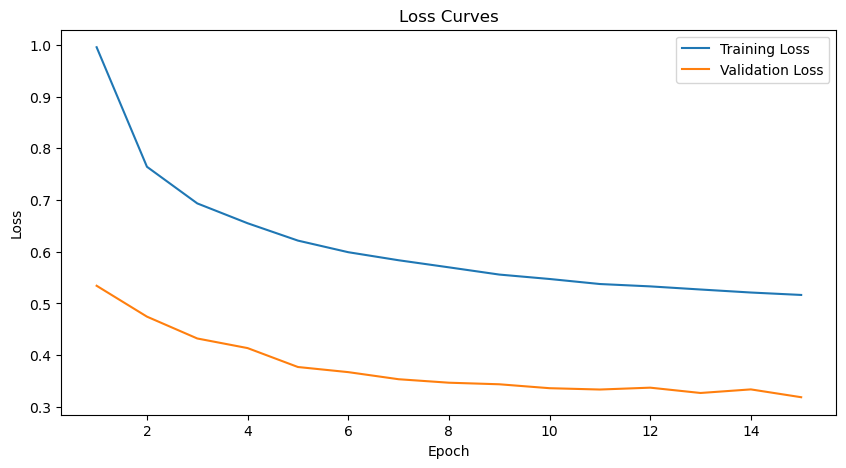

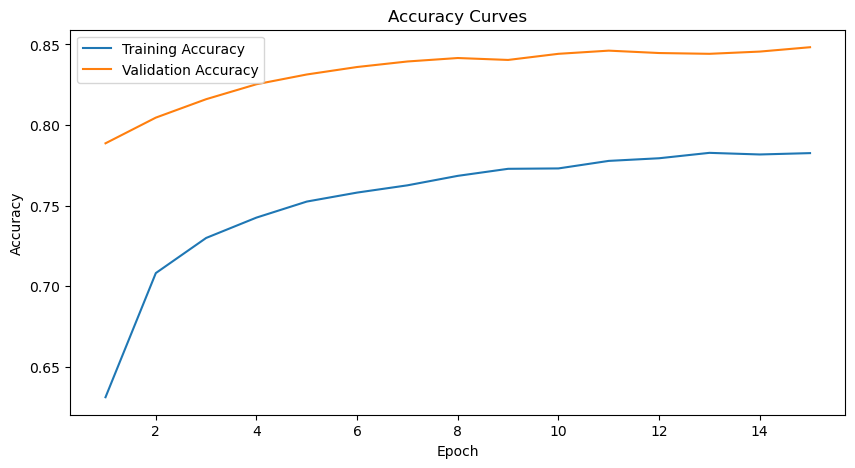

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over training batches with tqdm progress bar.
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase with tqdm.
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
    
    val_loss /= total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plotting Loss and Accuracy Curves 
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Evaluating our classifier on the test set

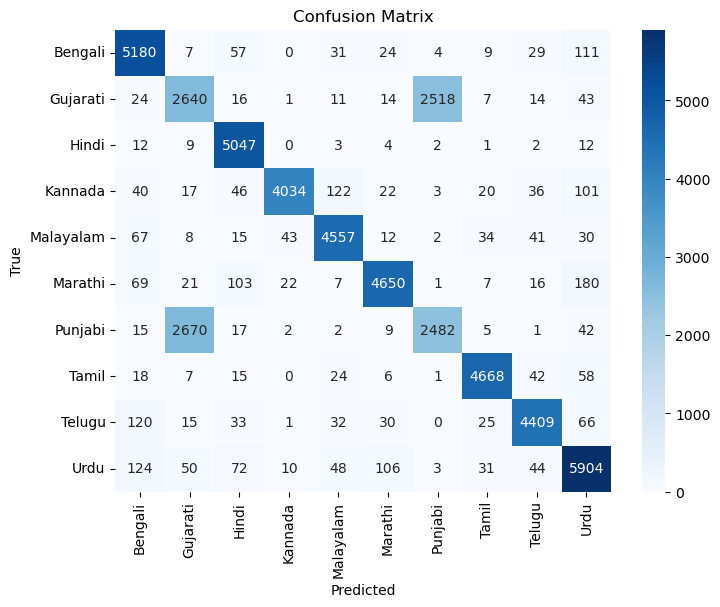

Classification Report:
              precision    recall  f1-score   support

     Bengali       0.91      0.95      0.93      5452
    Gujarati       0.48      0.50      0.49      5288
       Hindi       0.93      0.99      0.96      5092
     Kannada       0.98      0.91      0.94      4441
   Malayalam       0.94      0.95      0.94      4809
     Marathi       0.95      0.92      0.93      5076
     Punjabi       0.49      0.47      0.48      5245
       Tamil       0.97      0.96      0.97      4839
      Telugu       0.95      0.93      0.94      4731
        Urdu       0.90      0.92      0.91      6392

    accuracy                           0.85     51365
   macro avg       0.85      0.85      0.85     51365
weighted avg       0.85      0.85      0.85     51365



In [42]:
# Evaluation on Test Set
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.numpy())

# Confusion Matrix and Classification Report
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=unique_labels))
